In [74]:
# Custom Modules import
from util.data_loader import load_competitions, load_matches
#from util.team_strength_team_stats import calculate_team_stats, calculate_chances_from_played_games, calculate_features_based_on_certain_matchweeks, generate_dataset, create_home_away_pairs
from util.team_strength_team_stats import *
from statsbombpy import sb
from statsbombpy.api_client import NoAuthWarning

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore', category=NoAuthWarning)



from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, f1_score


%load_ext autoreload 
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Nuanced Team Strength Model

### Legend:  
🔴- to do <br>
🟠- in progress <br>
🟢- done <br>


### Used Features to quantify Team Strength:
- 🟢 Possession
- 🟢 Shots on Goal/ 🔴 on Target
- 🟢 Goals 
- 🟢 Goals_conceded
- 🟢 X_Goals
- 🟢 Passes 
- 🟠 Duels


### Other Features used to predict Match Outcomes:
- 🔴 Last 5 matches


### Output Predictions
- 🟢 Label of Match Status for Home Team
- 🔴 Betting Odds for both Home and Away Team

### Trainings/Test Daten
<br>


### Prior Baseline (Aus Literatur Outcome Prediction Modelle anschauen)


# Event Types, etc.

In [75]:
# Load data
matches = load_matches(competition_id=9, season_id=27)

test_event = sb.events(match_id=3890259)
test_event.shape

print('------------distinct_types----------------')
print(test_event['type'].unique())
print('------------pass_outcome----------------')
print(test_event['pass_outcome'].unique())
print('------------pass_type-------------')
print(test_event['pass_type'].unique())
print('------------pass_height----------------')
print(test_event['pass_height'].unique())

------------distinct_types----------------
['Starting XI' 'Half Start' 'Pass' 'Pressure' 'Ball Receipt*' 'Carry'
 'Duel' 'Clearance' 'Ball Recovery' 'Interception' 'Dispossessed'
 'Miscontrol' 'Block' 'Foul Committed' 'Foul Won' 'Shot' 'Goal Keeper'
 'Shield' '50/50' 'Dribble' 'Dribbled Past' 'Injury Stoppage' 'Player Off'
 'Player On' 'Half End' 'Error' 'Substitution' 'Tactical Shift']
------------pass_outcome----------------
[nan 'Incomplete' 'Out' 'Unknown' 'Pass Offside']
------------pass_type-------------
[nan 'Kick Off' 'Throw-in' 'Recovery' 'Free Kick' 'Goal Kick' 'Corner'
 'Interception']
------------pass_height----------------
[nan 'Ground Pass' 'High Pass' 'Low Pass']


# Getting the informations out of the event dataframes

## Single Match ( First Game of Bundesliga Season 15/16)

In [76]:
team_stats = calculate_team_stats(event=test_event)
team_stats

,team,completed_passes,total_passes,pass_completion_percentage,Shots,duels,xG,Goals,Goals Conceded,Possession
0,Bayern Munich,711,797,89.209536,22,76,2.24,5.0,0.0,78.0
1,Hamburger SV,150,240,62.500000,5,76,0.08,0.0,5.0,22.0


## All Matches of Bundesliga Season 15/16
The following Code takes long to execute, since its pulling the data from the statsbomb API (therefore its written locally in a csv file)

In [77]:
'''
all_team_stats = []
for _, match in matches.iterrows(): 
   match_id = match['match_id'] 
   match_date = match['match_date']
   match_week = match['match_week']
   #print(f'Start gathering Information from Match_ID = {match_id}')
   match_stats = calculate_team_stats(sb.events(match_id=match_id))
   match_stats['match_id'] = match_id
   match_stats['match_date'] = match_date
   match_stats['match_week'] = match_week
   all_team_stats.append(match_stats)
#   match_day += 1

team_stats = pd.concat(all_team_stats, ignore_index=True).set_index('match_id')
team_stats.to_csv('./Data/team_strength_stats.csv')
'''

"\nall_team_stats = []\nfor _, match in matches.iterrows(): \n   match_id = match['match_id'] \n   match_date = match['match_date']\n   match_week = match['match_week']\n   #print(f'Start gathering Information from Match_ID = {match_id}')\n   match_stats = calculate_team_stats(sb.events(match_id=match_id))\n   match_stats['match_id'] = match_id\n   match_stats['match_date'] = match_date\n   match_stats['match_week'] = match_week\n   all_team_stats.append(match_stats)\n#   match_day += 1\n\nteam_stats = pd.concat(all_team_stats, ignore_index=True).set_index('match_id')\nteam_stats.to_csv('./Data/team_strength_stats.csv')\n"

## Now in the Dataframe Team_Stats is every Stat for every Team for every Match

In [78]:
team_stats = pd.read_csv('./Data/team_strength_stats.csv')
team_stats['match_date'] = pd.to_datetime(team_stats['match_date'])
team_stats.sort_values('match_date')


#For example get the average pass completion percentage
team_stats.groupby(['team'])['pass_completion_percentage'].mean().reset_index(name='avg_pass_completion_percentage').sort_values('avg_pass_completion_percentage', ascending=False).head(20)

,team,avg_pass_completion_percentage
2,Bayern Munich,86.538269
3,Borussia Dortmund,82.751210
17,Wolfsburg,81.192701
4,Borussia Mönchengladbach,79.465608
14,Schalke 04,78.534258
11,Hertha Berlin,77.500490
0,Augsburg,74.321272
7,FC Köln,73.537738
1,Bayer Leverkusen,72.752820
12,Hoffenheim,72.739057


In [79]:

chances = calculate_chances_from_played_games(team_stats=team_stats, considered_matchweeks=list(range(1, 35)), round_decimals=None)
home_team = 'Bayern Munich'
away_team = 'Borussia Dortmund'
# This function creates a single entry which contains the stats of the teams, based on certain matchweeks and assigns the actual game result
single_datapoint = calculate_features_based_on_certain_matchweeks(home_team=home_team, away_team=away_team, chances=chances, matches=matches)

single_datapoint

,home_team,home_avg_completed_passes,home_avg_total_passes,home_avg_pass_comp_pct,home_avg_shots,home_avg_duels,home_avg_goals,away_team,away_avg_completed_passes,away_avg_total_passes,away_avg_pass_comp_pct,away_avg_shots,away_avg_duels,away_avg_goals,match_week,actual_result
0,Bayern Munich,662.205882,760.647059,86.538269,18.294118,68.058824,2.294118,Borussia Dortmund,565.911765,675.941176,82.75121,15.411765,72.5,2.352941,8,Home_Victory


In [80]:
train_dataset = generate_dataset(team_stats=team_stats, matches=matches, amount_of_weeks_to_simulate=150)


In [81]:
X = train_dataset.drop(columns=['actual_result','match_week'])  # All columns except the target
y = train_dataset['actual_result']  # Just the target column

grid_search, X_test, y_test, X_train, y_train, preprocessor  = train_and_evaluate_model(X, y)

# Access the best model
best_model = grid_search.best_estimator_

Class distribution in y_train: actual_result
Home_Victory    491
Home_Defeat     344
Draw            245
Name: count, dtype: int64
Fitting 5 folds for each of 15 candidates, totalling 75 fits

Best model: GradientBoostingClassifier(learning_rate=0.5)
Best params: {'model': GradientBoostingClassifier(), 'model__learning_rate': 0.5, 'model__n_estimators': 100}
Best CV score: 0.757


In [82]:
test_brier_scores = create_brier_scores(X_test = X_test, y_test = y_test, model = best_model, dataset = train_dataset)
                    
brier_scores_week = test_brier_scores.groupby('match_week').agg(brier_score=('brier_score', 'mean'))

print(f'Brier Score: {test_brier_scores['brier_score'].mean()}')

Brier Score: 0.3532249616819292


# Test with the Real Bundesliga 15/16 Matchdata

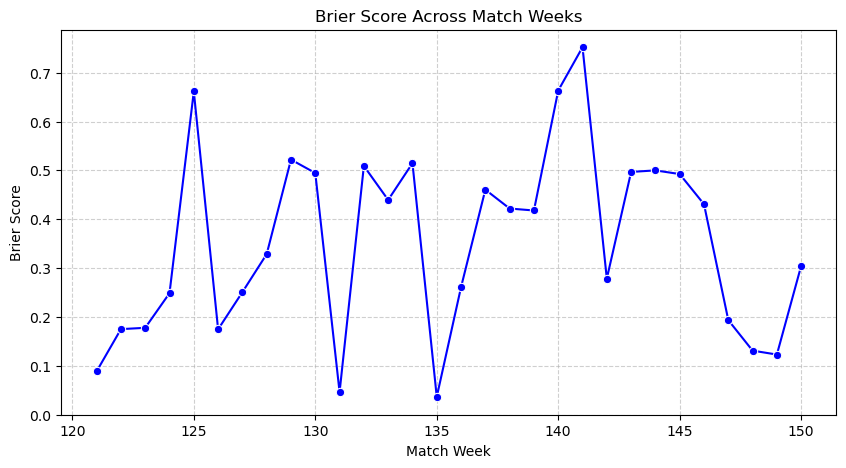

In [83]:
# Create the plot
plt.figure(figsize=(10, 5))
sns.lineplot(data=brier_scores_week, x='match_week', y='brier_score', marker='o', color='blue')

# Customize the plot
plt.xlabel('Match Week')
plt.ylabel('Brier Score')
plt.title('Brier Score Across Match Weeks')
plt.ylim(0, None)
plt.grid(True, linestyle='--', alpha=0.6)

# Show the plot
plt.show()

In [84]:
real_bundesliga_dataset = generate_real_dataset(team_stats=team_stats, matches=matches)

In [85]:
X_real = real_bundesliga_dataset.drop(columns=['actual_result','match_week'])  # All columns except the target
y_real = real_bundesliga_dataset['actual_result']  # Just the target column
predictions_real = best_model.predict(X_real)



              precision    recall  f1-score   support

        Draw       0.77      0.68      0.72        71
 Home_Defeat       0.84      0.87      0.86       100
Home_Victory       0.87      0.90      0.88       135

    accuracy                           0.84       306
   macro avg       0.83      0.82      0.82       306
weighted avg       0.84      0.84      0.84       306



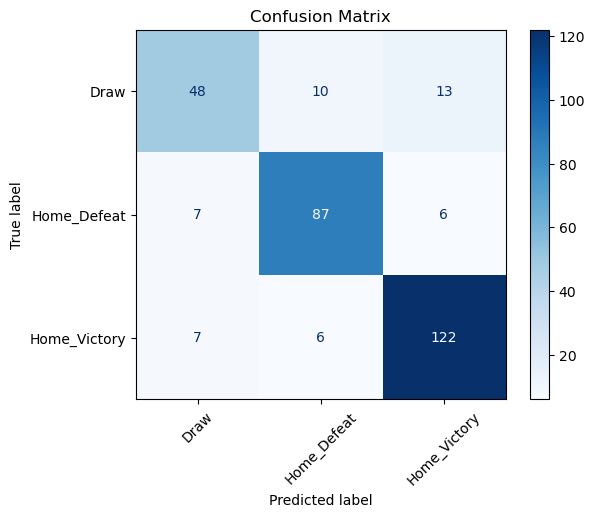

In [86]:
print(
    classification_report(
        y_real,          # True labels (strings)
        predictions_real,          # Predicted labels (strings)
        target_names=['Draw', 'Home_Defeat', 'Home_Victory']  # Optional: ensures consistent order
    )
)

ConfusionMatrixDisplay.from_predictions(
    y_real,
    predictions_real,
    display_labels=['Draw', 'Home_Defeat', 'Home_Victory'],
    cmap='Blues',
    xticks_rotation=45
)
plt.title('Confusion Matrix')
plt.show()

In [87]:
real_brier_scores = create_brier_scores(X_test = X_real, y_test = y_real, model = best_model, dataset = real_bundesliga_dataset)
                    
real_brier_scores_week = real_brier_scores.groupby('match_week').agg(brier_score=('brier_score', 'mean'))

print(f'Brier Score: {real_brier_scores['brier_score'].mean()}')

Brier Score: 0.257355795657101


In [88]:
results = pd.DataFrame(grid_search.cv_results_)
best_params_per_model = results.groupby(
    results['param_model'].apply(lambda x: x.__class__.__name__)
).apply(
    lambda x: x.loc[x['mean_test_score'].idxmax(), 'params']
).to_dict()


best_models = {}
for model_name, params in best_params_per_model.items():
    # Create pipeline with best parameters
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', params['model'].set_params(**{
            k.split('__')[1]: v for k, v in params.items() 
            if k != 'model'
        }))
    ])
    
    # Retrain on full training data
    pipe.fit(X_train, y_train)
    best_models[model_name] = pipe

c:\ProgramData\Anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GradientBoostingClassifier - Overall Brier Score: 0.2593
LogisticRegression - Overall Brier Score: 0.5124
RandomForestClassifier - Overall Brier Score: 0.3701
SVC - Overall Brier Score: 0.5104


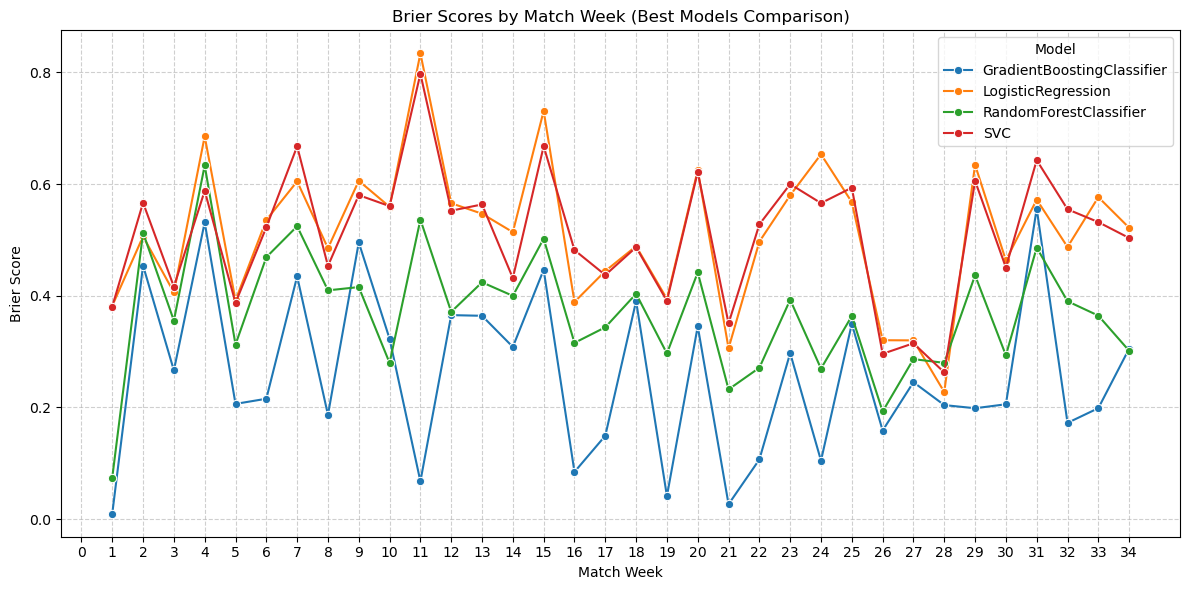

In [92]:
# 1. Calculate Brier scores for each best model
brier_results = {}
for model_name, model in best_models.items():
    # Get predictions and outcomes
    preds_and_outcomes = create_brier_scores(
        X_test=X_real,
        y_test=y_real,
        model=model,
        dataset=real_bundesliga_dataset
    )
    
    weekly_scores= preds_and_outcomes.groupby('match_week').agg(brier_score=('brier_score', 'mean'))

    # Store results
    brier_results[model_name] = {
        'predictions': preds_and_outcomes,
        'weekly_scores': weekly_scores,
        'overall_score': preds_and_outcomes['brier_score'].mean()
    }
    
    # Print summary
    print(f"{model_name} - Overall Brier Score: {brier_results[model_name]['overall_score']:.4f}")

# 2. Plot weekly Brier scores comparison
plt.figure(figsize=(12, 6))

for model_name, results in brier_results.items():
    weekly_scores = results['weekly_scores'].reset_index()
    weekly_scores['model'] = model_name
    sns.lineplot(
        data=weekly_scores,
        x='match_week',
        y='brier_score',
        marker='o',
        label=model_name
    )

# Customize plot
plt.title('Brier Scores by Match Week (Best Models Comparison)')
plt.xlabel('Match Week')
plt.ylabel('Brier Score')
plt.xticks(range(0, 35))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

In [90]:
real_brier_scores2 = create_brier_scores(X_test = X_real, y_test = y_real, model = best_models['GradientBoostingClassifier'], dataset = real_bundesliga_dataset)
                    
real_brier_scores_week2 = real_brier_scores2.groupby('match_week').agg(brier_score=('brier_score', 'mean'))

print(f'Brier Score: {real_brier_scores2['brier_score'].mean()}')

Brier Score: 0.259320965874639


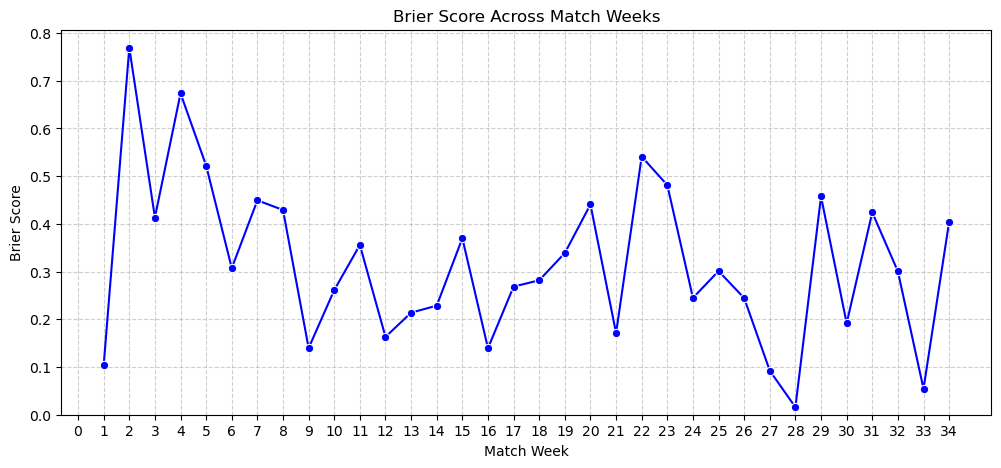

In [ ]:
# Create the plot
plt.figure(figsize=(12, 5))
sns.lineplot(data=real_brier_scores_week, x='match_week', y='brier_score', marker='o', color='blue')

# Customize the plot
plt.xlabel('Match Week')
plt.ylabel('Brier Score')
plt.title('Brier Score Across Match Weeks')
plt.ylim(0, None)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(range(35))  # range(35) generates numbers 0 through 34


# Show the plot
plt.show()

# Gathering some infomation about Teams

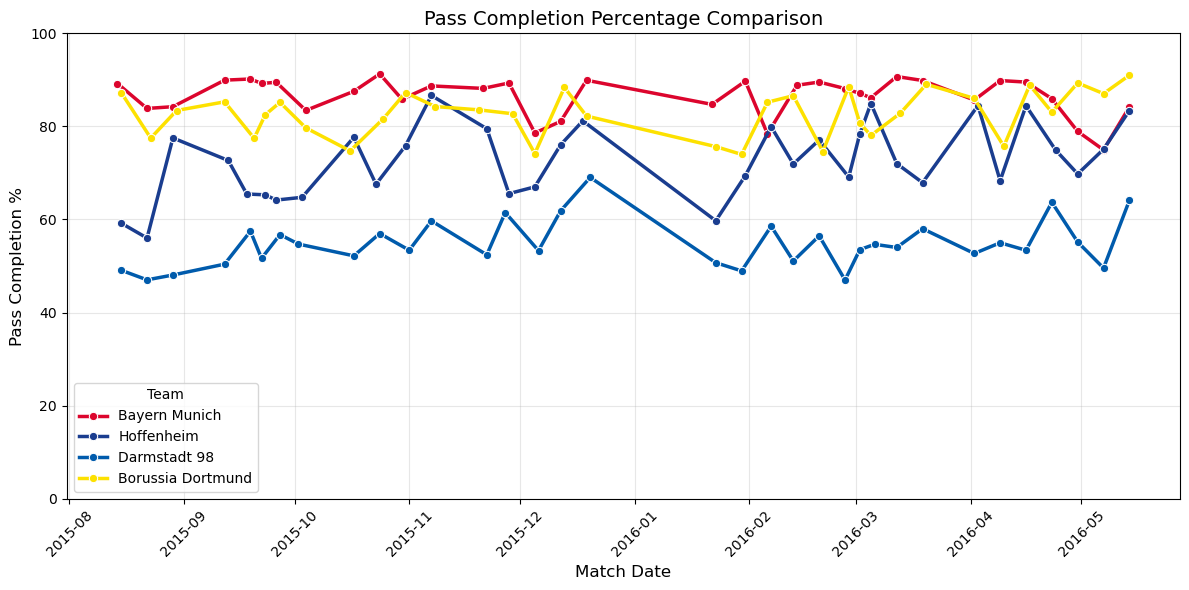

In [ ]:
pass_completion_rates = team_stats[['team', 'match_date', 'pass_completion_percentage']]

teams_to_plot = ['Bayern Munich', 'Borussia Dortmund', 'Darmstadt 98', 'Hoffenheim']
multi_team_data = pass_completion_rates[pass_completion_rates['team'].isin(teams_to_plot)]


custom_colors = {
    'Bayern Munich': '#DC052D',        # Red
    'Borussia Dortmund': '#FDE100',    # Yellow
    'Darmstadt 98': '#005BAC',         # Blue
    'Hoffenheim': '#1A3D8F'            # Dark Blue
}
# Create plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=multi_team_data,
             x='match_date',
             y='pass_completion_percentage',
             hue='team',
             marker='o',
             palette= custom_colors,
             linewidth=2.5)

plt.title('Pass Completion Percentage Comparison', fontsize=14)
plt.xlabel('Match Date', fontsize=12)
plt.ylabel('Pass Completion %', fontsize=12)
plt.legend(title='Team')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.ylim(0, 100)
plt.tight_layout()
plt.show()